In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

from PIL import Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Read images and l
retro_folder = '/content/drive/MyDrive/Main/Retro'
modern_folder = '/content/drive/MyDrive/Main/Modern'
prototxt_path = '/content/drive/MyDrive/Main/colorization_deploy_v2.prototxt'
model_path = '/content/drive/MyDrive/Main/colorization_release_v2.caffemodel'
kernel_path = '/content/drive/MyDrive/Main/pts_in_hull.npy'
image_path = '/content/drive/MyDrive/Main/processed_image.jpg'

# Function to read images from a folder
def read_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

retro_images = read_images_from_folder(retro_folder)
modern_images = read_images_from_folder(modern_folder)


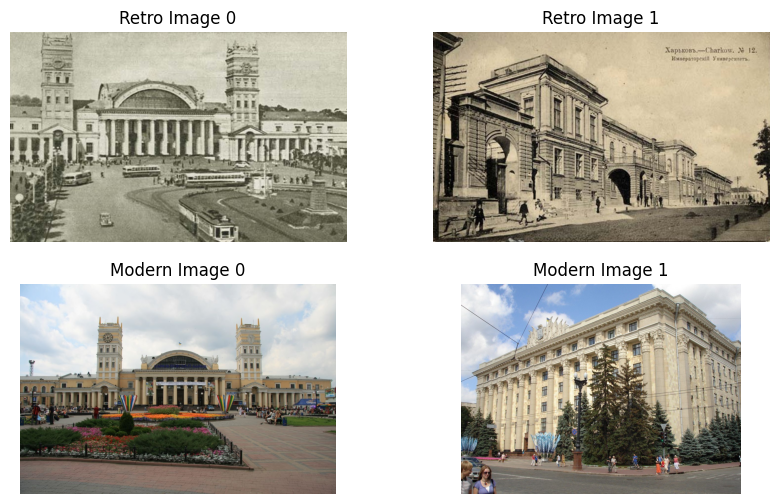

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Show first two images from retro folder
for i, index in enumerate([0, 1]):
        rgb_image = cv2.cvtColor(retro_images[index], cv2.COLOR_BGR2RGB)
        axs[0, i].imshow(rgb_image)
        axs[0, i].set_title('Retro Image {}'.format(i))
        axs[0, i].axis('off')  # Hide axes

    # Show selected images from modern folder
for i, index in enumerate([8, 9]):
        rgb_image = cv2.cvtColor(modern_images[index], cv2.COLOR_BGR2RGB)
        axs[1, i].imshow(rgb_image)
        axs[1, i].set_title('Modern Image {}'.format(i))
        axs[1, i].axis('off')  # Hide axes

plt.show()

In [ ]:
def preprocess_images(images, size=(224, 224)):
    resized_images = [cv2.resize(img, size) for img in images]

    lab_images = [cv2.cvtColor(img, cv2.COLOR_BGR2LAB) for img in resized_images]

    normalized_images = [(img[:,:,0] / 255.0, (img[:,:,1:]) / 255.0) for img in lab_images]

    return normalized_images

retro_images_LAB_normalized = preprocess_images(read_images_from_folder(retro_folder))
modern_images_LAB_normalized = preprocess_images(read_images_from_folder(modern_folder))


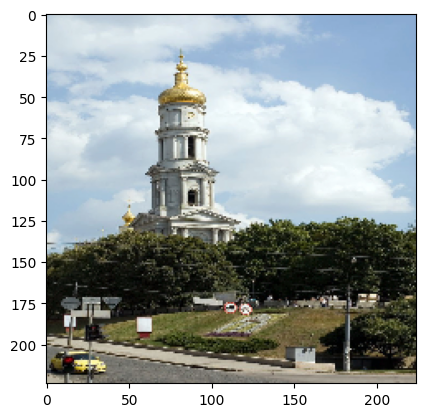

In [ ]:
def postprocess_image(image):
    # denormalization
    denormalized_image = (image[0]*255.0, image[1]*255.0)

    # concatenating L, a and b channels back into one image
    lab_image = np.concatenate([denormalized_image[0][...,np.newaxis], denormalized_image[1]], axis=2)

    # converting image from LAB to RGB
    lab_image = lab_image.astype('uint8')
    rgb_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)

    return rgb_image

# Postprocess the first retro image
rgb_image = postprocess_image(modern_images_LAB_normalized[1])

# Now you can display it using matplotlib
plt.imshow(rgb_image)
plt.show()

In [ ]:
modern_images_L = np.array([img[0] for img in modern_images_LAB_normalized])
modern_images_AB = np.array([img[1] for img in modern_images_LAB_normalized])

# Split the images into training and validation sets
train_images_L, val_images_L, train_images_AB, val_images_AB = train_test_split(
    modern_images_L, modern_images_AB, test_size=0.2, random_state=42
)

In [ ]:
def create_model(input_shape=(224, 224, 1)):
    # Define input
    inputs = Input(input_shape)

    # Encoding path
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoding path
    up3 = UpSampling2D(size=(2, 2))(pool2)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(up3)

    up4 = UpSampling2D(size=(2, 2))(conv3)
    conv4 = Conv2D(2, (3, 3), activation='tanh', padding='same')(up4)

    # Define model
    model = Model(inputs=[inputs], outputs=[conv4])

    return model


# Create and compile the model
model = create_model()
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])


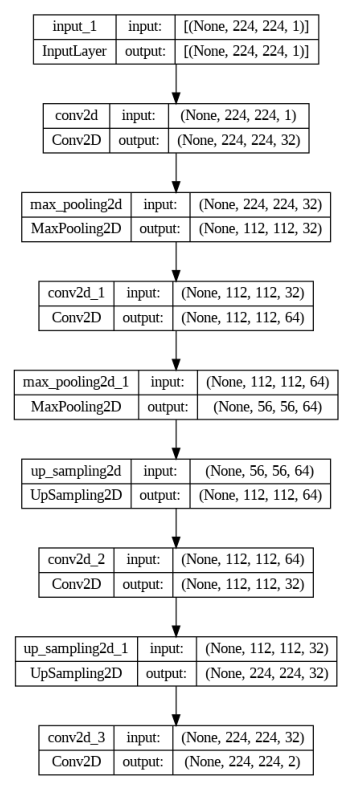

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import matplotlib.pyplot as plt

# Візуалізувати модель
plot = plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

# Завантажити та відобразити зображення
img = plt.imread('model.png')
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
history = model.fit(train_images_L, train_images_AB, validation_data=(val_images_L, val_images_AB), epochs=10, batch_size=16)

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.4867 - accuracy: 0.4842 - val_loss: 0.3879 - val_accuracy: 0.4236
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.3813 - accuracy: 0.4257 - val_loss: 0.2916 - val_accuracy: 0.4377
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.2814 - accuracy: 0.4778 - val_loss: 0.1848 - val_accuracy: 0.4347
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.1693 - accuracy: 0.4718 - val_loss: 0.1372 - val_accuracy: 0.4349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.1263 - accuracy: 0.4711 - val_loss: 0.1611 - val_accuracy: 0.4349
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.1539 - accuracy: 0.4711 - val_loss: 0.1830 - val_accuracy: 0.4340
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.1793 - accuracy: 0.4731 - val_loss: 0.1873 - val_accuracy: 0.5413
Epoch 8/10
1/1 [=========================

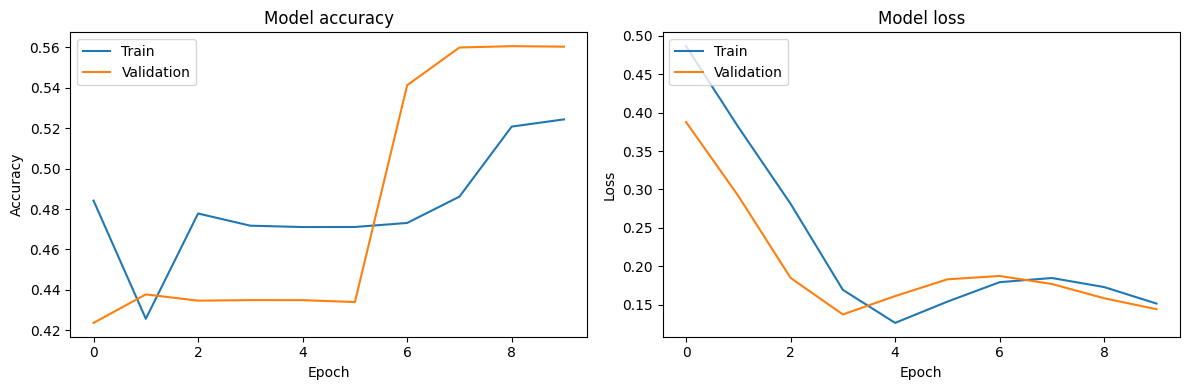

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Loading the model after training
net = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)

points = np.load(kernel_path)
points = points.transpose().reshape(2, 313, 1, 1)

net.getLayer(net.getLayerId('class8_ab')).blobs = [points.astype(np.float32)]
net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full([1, 313], 2.606, np.float32)]

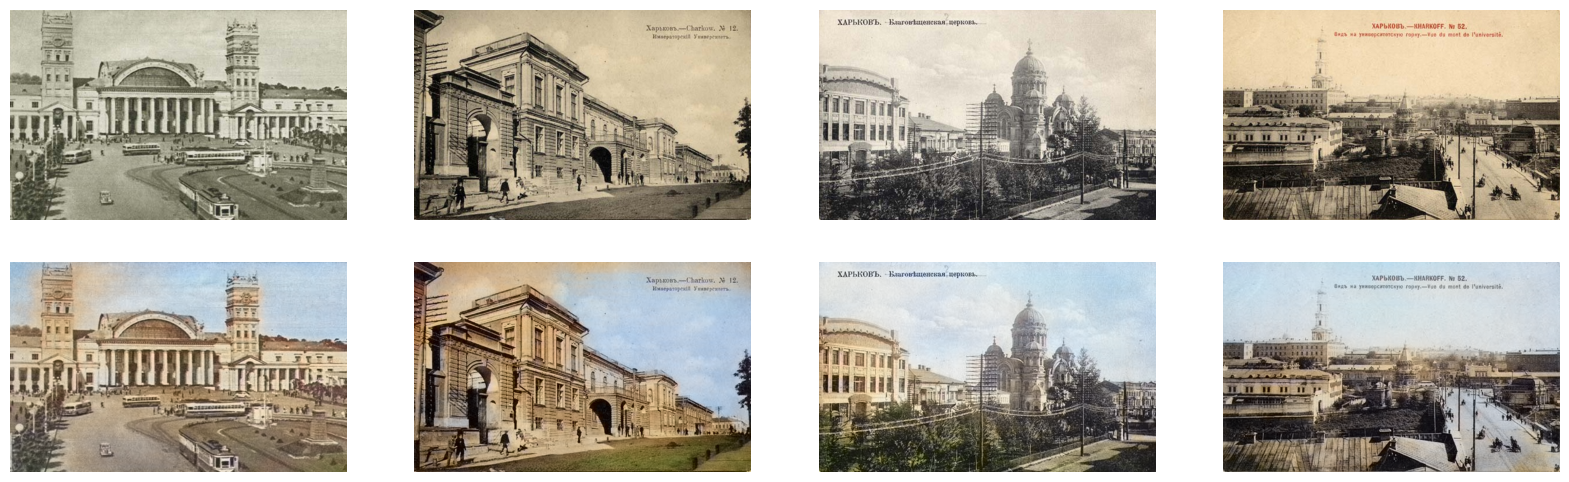

In [ ]:
bw_image_indices = [0, 1, 5, 9]
bw_images = [retro_images[i] for i in bw_image_indices]

fig, axs = plt.subplots(2, 4, figsize=(20, 6))

for i, bw_image in enumerate(bw_images):

  # Display the original image in the first row
  axs[0, i].imshow(cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB))
  axs[0, i].axis('off')  # To hide the axis labels in each subplot

  # Normalize the image
  normalized = bw_image.astype("float32") / 255.0
  lab = cv2.cvtColor(normalized, cv2.COLOR_BGR2LAB)
  resized = cv2.resize(lab, (224, 224))
  L = cv2.split(resized)[0]
  L -= 50

  # Network Processing and Result Display
  net.setInput(cv2.dnn.blobFromImage(L))

  # Get the result from the network
  ab = net.forward()[0, :, :, :].transpose((1,2,0))
  ab = cv2.resize(ab, (bw_image.shape[1], bw_image.shape[0]))

  L = cv2.split(lab)[0]

  colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)
  colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
  colorized = (255.0 * colorized).astype("uint8")
  rgb_image = cv2.cvtColor(colorized, cv2.COLOR_BGR2RGB)

  # Display the colorized image in the second row
  axs[1, i].imshow(rgb_image)
  axs[1, i].axis('off')  # To hide the axis labels in each subplot

plt.show()